In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
import concurrent.futures as cf
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file = "https://raw.githubusercontent.com/shalinramduth/ST444-Project/main/ObesityDataSet_raw_and_data_sinthetic.csv"
df = pd.read_csv(file)

# Round age, and Weight to integer; Round Height to 2 decimal places; As for other float64-type varialbes, they should be integer
integer = ["Age", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
df[integer] = df[integer].apply(np.int64)
df = df.round({"Height": 2})

# convert categorical variables
for column in df.columns:
  if df[column].dtypes == "object":
    df[column] = pd.factorize(df[column])[0]
        
# define x and y
x = df[df.columns[0:16]]; y = df[df.columns[16]]

times = list(np.linspace(100, 5000, num=10)) # create equal spaced sample size and no of samples values
times = [int(x) for x in times]

workers = [2,4,8] # number of processes that will be attempted to run at the same time
# the code was run on a laptop with 4 cores

df_time = pd.DataFrame(columns = ['no of samples'])
df_time['no of samples'] = times

In [3]:
# function that draws bootstrap samples

def h(n):
  X = df.sample(n=n,replace=True) # sample from dataset
  return(np.mean(X))

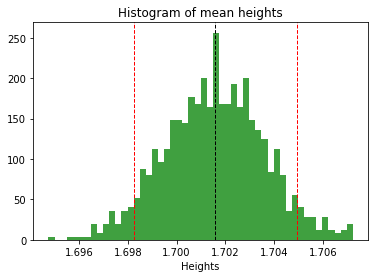

In [4]:
#Histogram of mean heights

hist = []
for x in range(1000):
  hist.append(h(2000))

hist2 = [his[2] for his in hist]

plt.hist(hist2, 50, density=True, facecolor='g', alpha=0.75)
plt.axvline(np.mean(hist2), color='k', linestyle='dashed', linewidth=1)
plt.axvline(np.percentile(hist2, 5), linestyle='dashed', linewidth=1, color = 'r')
plt.axvline(np.percentile(hist2, 95), linestyle='dashed', linewidth=1, color = 'r')
plt.title('Histogram of Mean Heights')
plt.xlabel('Heights')
plt.show()

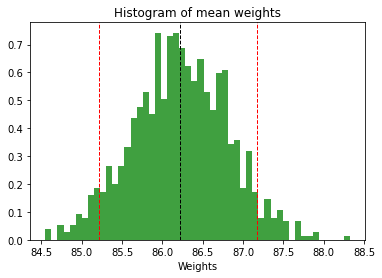

In [5]:
#Histogram of mean weights

hist3 = [his[3] for his in hist]
plt.hist(hist3, 50, density=True, facecolor='g', alpha=0.75)
plt.axvline(np.mean(hist3), color='k', linestyle='dashed', linewidth=1)
plt.axvline(np.percentile(hist3, 5), linestyle='dashed', linewidth=1, color = 'r')
plt.axvline(np.percentile(hist3, 95), linestyle='dashed', linewidth=1, color = 'r')
plt.title('Histogram of Mean Weights')
plt.xlabel('Weights')
plt.show()

In [6]:
# serial function for bootstrap

#function appends the calculated statistics to these lists
meanli = []
stdli = []

# n = sample size; m = no of samples
def serial(n,m):
  #timing
  st = time.perf_counter()
  means = []
  for a in range(m):
    means.append(h(n))
  #mean and standard deviation of bootstrapped means are the calculated statistics
  meanli.append(np.mean(means,axis = 0))
  stdli.append(np.std(means, axis = 0))
  en = time.perf_counter()
  #returns the time taken
  return(en-st)

perf = []
for b in times:
  perf.append(serial(2000,b))
df_time['time taken serial'] = perf
df_time

,no of samples,time taken serial
0,100,0.252560
1,644,1.530673
2,1188,2.780544
3,1733,4.055416
4,2277,5.322374
5,2822,6.733276
6,3366,7.883366
7,3911,9.192868
8,4455,10.585519
9,5000,11.888679


In [7]:
# parallel function for bootstrap

#function appends the calculated statistics to these lists
meanli2 = []
stdli2 = []

def parallel(n,m,w):

  #n is how large each sample is, m is how many samples are taken
  inputs = [n]*m
  #timing the function
  start = time.perf_counter()

  if __name__ == "__main__":
    #uses current.futures module
    #with statement allows us to use a context manager
    with cf.ProcessPoolExecutor(max_workers = w) as ex:

      #uses map to map function h to the inputs
      results = ex.map(h, inputs)

      #the results are a generator object, which we convert to a list
      means = [x for x in results]

      #append to lists
      meanli2.append(np.mean(means))
      stdli2.append(np.std(means))

  finish = time.perf_counter()

            #time taken
  t = finish - start
  return(t)


for a in workers:
  p = []
  for b in times:
    p.append(parallel(2000,b,a))
  df_time['time taken parallel ({} workers)'.format(a)] = p
df_time
  


,no of samples,time taken serial,time taken parallel (2 workers),time taken parallel (4 workers),time taken parallel (8 workers)
0,100,0.252560,0.301560,0.322767,0.402755
1,644,1.530673,1.758130,1.886628,1.904797
2,1188,2.780544,3.172207,3.226367,3.660516
3,1733,4.055416,4.676689,4.885229,4.926422
4,2277,5.322374,6.183498,6.237864,6.593864
5,2822,6.733276,7.633496,7.886325,8.308208
6,3366,7.883366,9.164450,9.288833,9.626815
7,3911,9.192868,10.667589,10.828122,11.299560
8,4455,10.585519,12.026127,12.567362,12.821971
9,5000,11.888679,13.597577,13.977878,14.664090


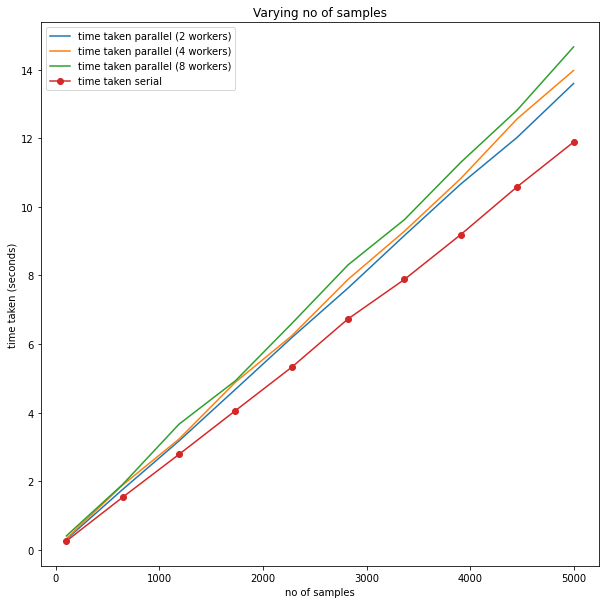

In [8]:
# visualization of time taken serial function and parallel function
plt.figure(figsize = (10,10))
for x in workers:
  plt.plot('no of samples', 'time taken parallel ({} workers)'.format(x), data=df_time, marker = '')

plt.plot('no of samples', 'time taken serial', data=df_time, marker = 'o')
#plt.plot()

plt.legend()
plt.xlabel('no of samples'); plt.ylabel('time taken (seconds)')
plt.title('Varying no of samples')

plt.show()

In [9]:
# serial function for bootstrap

df_time2 = pd.DataFrame(columns = ['sample size'])
df_time2['sample size'] = times

#function appends the calculated statistics to these lists
meanli = []
stdli = []

# changing sample size
perf = []
for b in times:
  perf.append(serial(b,1000))
df_time2['time taken serial'] = perf
df_time2

,sample size,time taken serial
0,100,2.261377
1,644,2.204839
2,1188,2.259955
3,1733,2.373510
4,2277,2.444883
5,2822,2.451300
6,3366,2.533191
7,3911,2.564601
8,4455,2.623370
9,5000,2.683146


In [10]:
# parallel changing sample size

#function appends the calculated statistics to these lists
meanli2 = []
stdli2 = []

for a in workers:
  p = []
  for b in times:
    p.append(parallel(b,1000,a))
  df_time2['time taken parallel ({} workers)'.format(a)] = p
df_time2

,sample size,time taken serial,time taken parallel (2 workers),time taken parallel (4 workers),time taken parallel (8 workers)
0,100,2.261377,2.567328,2.632429,2.790316
1,644,2.204839,2.703529,2.776848,2.810497
2,1188,2.259955,2.667521,2.740000,2.885303
3,1733,2.373510,2.669700,2.917076,2.945064
4,2277,2.444883,2.726191,2.841810,3.076294
5,2822,2.451300,2.783944,2.836944,3.067486
6,3366,2.533191,2.943618,2.943302,3.122060
7,3911,2.564601,2.960588,3.048520,3.134685
8,4455,2.623370,2.964613,3.041608,3.233006
9,5000,2.683146,2.952054,2.995067,3.211048


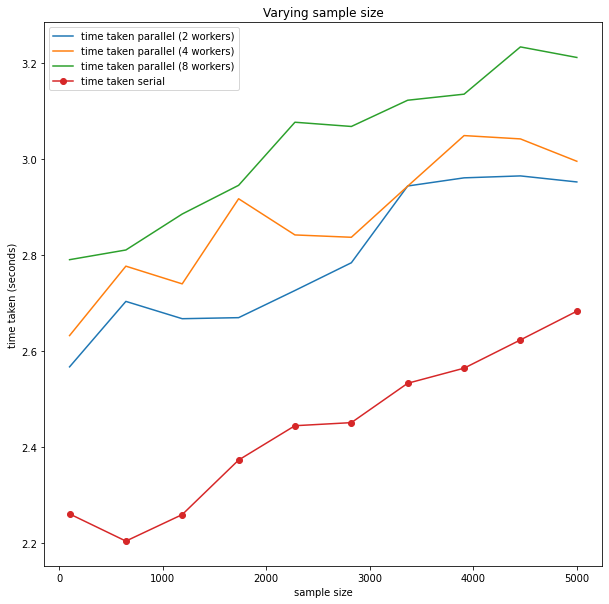

In [11]:
# visualization of time taken for the whole process
plt.figure(figsize = (10,10))
for x in workers:
  plt.plot('sample size', 'time taken parallel ({} workers)'.format(x), data=df_time2, marker = '')

plt.plot('sample size', 'time taken serial', data=df_time2, marker = 'o')

plt.legend()
plt.xlabel('sample size'); plt.ylabel('time taken (seconds)')
plt.title('Varying sample size')
plt.show()

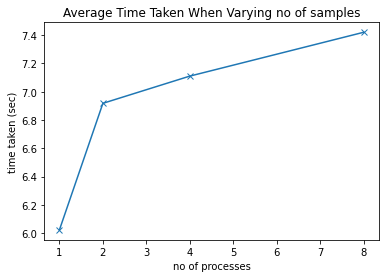

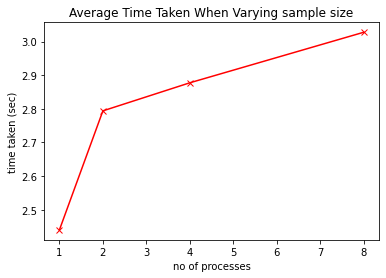

In [23]:
# Average time for each number of processes (serial function represented as 1 process)

ax1 = plt.plot([1,2,4,8],np.mean(df_time)[1:], marker = 'x')
plt.title('Average Time Taken When Varying no of samples')
plt.xlabel('no of processes')
plt.ylabel('time taken (sec)')
plt.show()

ax2 = plt.plot([1,2,4,8],np.mean(df_time2)[1:], marker = 'x', color = 'r')
plt.title('Average Time Taken When Varying sample size')
plt.xlabel('no of processes')
plt.ylabel('time taken (sec)')
plt.show()

In [13]:
#sampling and fitting the decision tree (but test set is the set not covered by the sampling) and return accuracy score

xx = df[df.columns[0:16]]; xy = df[df.columns[16]]

def g(n):
  big = list(xx.index)
  X = xx.sample(n=n,replace=True) # sample from training dataset
  #indexes of samples
  ind = set(X.index)
  Y = xy.loc[list(X.index)]
  #indexes of datapoints not in the sample
  rest = [x for x in big if x not in ind]
  xt = xx.loc[rest]
  yt = xy.loc[rest]
  clf = tree.DecisionTreeClassifier().fit(X,Y).predict(xt)
  return(accuracy_score(clf,yt))

df_time3 = pd.DataFrame(columns = ['no of samples'])
df_time3['no of samples'] = times

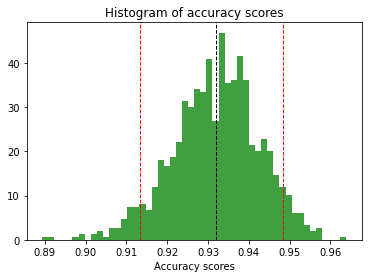

In [14]:
#histogram of accuracy scores for 1000 trials

hist = []

for x in range(1000):
  hist.append(g(2000))

plt.hist(hist, 50, density=True, facecolor='g', alpha=0.75)
plt.axvline(np.mean(hist), color='k', linestyle='dashed', linewidth=1)
#line for 5th percentile in accuracy scores calculated
plt.axvline(np.percentile(hist, 5), linestyle='dashed', linewidth=1, color = 'r')
#line for 95th percentile in accuracy scores calculated
plt.axvline(np.percentile(hist, 95), linestyle='dashed', linewidth=1, color = 'r')
plt.title('Histogram of accuracy scores')
plt.xlabel('Accuracy scores')
plt.show()

In [15]:
# serial function model evaluation

#function appends the calculated statistics to these lists
meanli = []
stdli = []

# n = sample size; m = no of samples
def serial2(n,m):
  st = time.perf_counter()

  meanacc = []
  for a in range(m):
    meanacc.append(g(n))
  #mean and standard deviation of bootstrapped means are the calculated statistics
  meanli.append(np.mean(meanacc,axis = 0))
  stdli.append(np.std(meanacc, axis = 0))
  en = time.perf_counter()
  return(en-st)

# changing no of samples

perf = []
for b in times:
  perf.append(serial2(2000,b))
df_time3['time taken serial'] = perf
df_time3

,no of samples,time taken serial
0,100,0.872729
1,644,5.543095
2,1188,10.409358
3,1733,15.036856
4,2277,19.751657
5,2822,24.601849
6,3366,29.296731
7,3911,35.164027
8,4455,40.051835
9,5000,44.210293


In [16]:
# parallel function model evaluation

#function appends the calculated statistics to these lists
meanli2 = []
stdli2 = []

def parallel2(n,m,w):

  #n is how large each sample is, m is how many samples are taken
  inputs = [n]*m
  #timing the function
  start = time.perf_counter()

  if __name__ == "__main__":
    #uses current.futures module
    #with statement allows us to use a context manager
    with cf.ProcessPoolExecutor(max_workers = w) as ex:
      #uses map to match the function to the inputs
      results = ex.map(g, inputs)
      #ex.map returns a generator object which we need to convert to a list
      acc = [x for x in results]
      #mean and standard deviation of bootstrapped means are the calculated statistics
      meanli2.append(np.mean(acc,axis = 0))
      stdli2.append(np.std(acc, axis = 0))
    
  finish = time.perf_counter()
    #time taken
  t = finish - start
  return(t)

# changing no of samples

for a in workers:
  p = []
  for b in times:
    p.append(parallel2(2000,b,a))
  df_time3['time taken parallel ({} workers)'.format(a)] = p
df_time3

,no of samples,time taken serial,time taken parallel (2 workers),time taken parallel (4 workers),time taken parallel (8 workers)
0,100,0.872729,0.793564,0.799652,0.929659
1,644,5.543095,4.696928,4.827726,5.288911
2,1188,10.409358,8.499935,8.885521,9.774140
3,1733,15.036856,12.593722,13.379350,14.008999
4,2277,19.751657,16.304037,17.996715,18.351491
5,2822,24.601849,20.294988,22.061294,22.816077
6,3366,29.296731,24.031145,26.465860,27.217646
7,3911,35.164027,27.930116,30.803407,31.367496
8,4455,40.051835,32.069395,35.039618,36.101634
9,5000,44.210293,36.015815,39.170945,40.158827


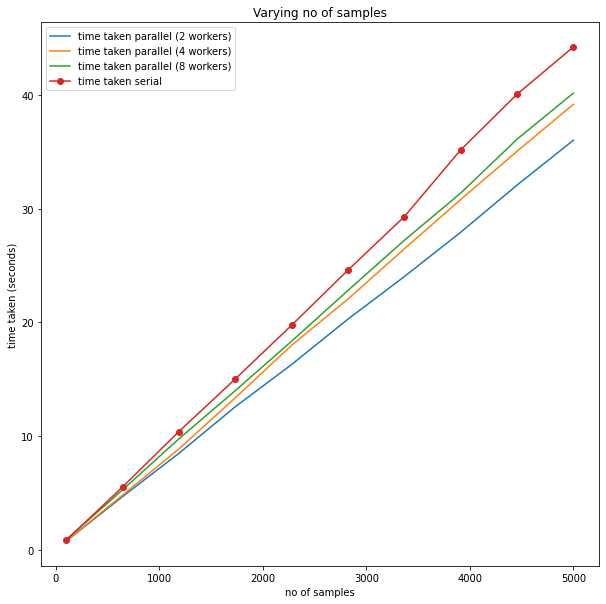

In [17]:
# visualization of time taken for the whole process
plt.figure(figsize = (10,10))
for x in workers:
  plt.plot('no of samples', 'time taken parallel ({} workers)'.format(x), data=df_time3, marker = '')

plt.plot('no of samples', 'time taken serial', data=df_time3, marker = 'o')
plt.legend()
plt.xlabel('no of samples'); plt.ylabel('time taken (seconds)')
plt.title('Varying no of samples')
plt.show()

In [18]:
# vary sample size serial

df_time4 = pd.DataFrame(columns = ['sample size'])
df_time4['sample size'] = times

#function appends the calculated statistics to these lists
meanli = []
stdli = []

perf = []
for b in times:
  perf.append(serial2(b,1000))

df_time4['time taken serial'] = perf
df_time4

,sample size,time taken serial
0,100,4.805807
1,644,6.066583
2,1188,7.275062
3,1733,8.652409
4,2277,9.965007
5,2822,11.394001
6,3366,12.472103
7,3911,13.790985
8,4455,15.156297
9,5000,16.510237


In [19]:
# vary no of samples parallel

#function appends the calculated statistics to these lists
meanli2 = []
stdli2 = []

for a in workers:
  p = []
  for b in times:
    p.append(parallel2(b,1000,a))
  df_time4['time taken parallel ({} workers)'.format(a)] = p
df_time4

,sample size,time taken serial,time taken parallel (2 workers),time taken parallel (4 workers),time taken parallel (8 workers)
0,100,4.805807,4.487603,4.720152,4.964682
1,644,6.066583,5.385076,5.724034,5.886392
2,1188,7.275062,6.377500,6.481371,6.779292
3,1733,8.652409,7.174129,7.500858,7.744033
4,2277,9.965007,8.223144,8.807773,8.705703
5,2822,11.394001,9.148662,9.340420,9.748797
6,3366,12.472103,10.094760,10.218994,10.531752
7,3911,13.790985,11.008092,11.156042,11.547458
8,4455,15.156297,12.113049,12.146468,12.562071
9,5000,16.510237,12.918062,13.190234,13.407057


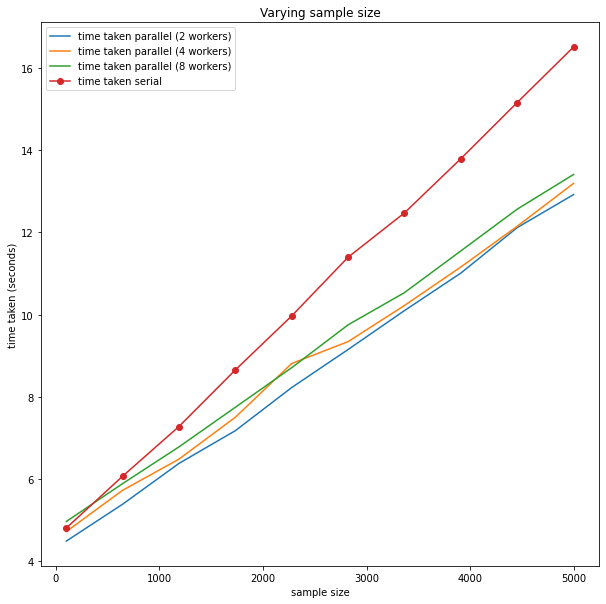

In [20]:
# visualization of time taken for the whole process
plt.figure(figsize = (10,10))
for x in workers:
  plt.plot('sample size', 'time taken parallel ({} workers)'.format(x), data=df_time4, marker = '')

plt.plot('sample size', 'time taken serial', data=df_time4, marker = 'o')
plt.legend()
plt.xlabel('sample size'); plt.ylabel('time taken (seconds)')
plt.title('Varying sample size')
plt.show()

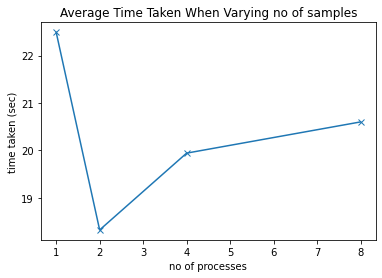

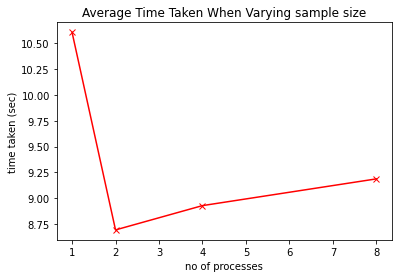

In [22]:
# Average time for each number of processes (serial function represented as 1 process)

ax1 = plt.plot([1,2,4,8],np.mean(df_time3)[1:], marker = 'x')
plt.title('Average Time Taken When Varying no of samples')
plt.xlabel('no of processes')
plt.ylabel('time taken (sec)')
plt.show()

ax2 = plt.plot([1,2,4,8],np.mean(df_time4)[1:], marker = 'x', color = 'r')
plt.title('Average Time Taken When Varying sample size')
plt.xlabel('no of processes')
plt.ylabel('time taken (sec)')
plt.show()